# CSC375: Deep Learning Final Project
Ryan Fischbach and Alex Weinstein 

Dr. Pauca

December 5th, 2020

## Convolutional Neural Networks and Image Classification on White Blood Cell Scans

### Background
The medical field has benefited significantly from machine learning and deep learning. Specifically the prevalence of image data and other patient health data has facilitated neural networks automating the classification of image data to save healthcare worker’s time. While looking for datasets, we were inspired by the recent image classification algorithms that can classify a patient as having COVID-19 or not having COVID-19 from chest X-ray scans. These Convolutional Neural Networks (CNNs) can help save doctor’s time while diagnosing scans, allowing them to focus on other patients or other more important work.

### Methodology
For this problem, we closely followed the methodology outlined in chapter 4.5 of Deep Learning with Python, which offers a workflow to solve a machine-learning problem:

#### 1. Defining our problem and assembling a dataset

Our problem statement is: what is the best type of deep learning model to classify scans from patient images and what performance can we achieve from this model? We are curious to see the resulting performance metrics and if this automated approach to identifying new samples from patients can perform well enough to justify this method being used instead of a professional going through all images individually. Additionally, we are interested in what convolutional bases from other pre-trained models can be implemented in a healthcare setting via transfer learning to maximize our performance metrics. 
We came across a dataset of white blood cell images from Kaggle and decided to pursue classification via CNNs. (https://www.kaggle.com/paultimothymooney/blood-cells). 


In [ ]:
#import keras library and check version
import keras
keras.__version__

'2.4.3'

In [ ]:
#import required libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import to_categorical
import pandas as pd

In [ ]:
#mount drive to acquire data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, shutil

In [ ]:
# base directory for reference
base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset2-master/images'

In [ ]:
from tqdm import tqdm
import cv2
import scipy.misc

X_train = []
y_train = []
#loop through train directory and create labels/input images
for wbc_type in os.listdir(base_dir + '/TRAIN'):
    if not wbc_type.startswith('.'):
        if wbc_type in ['NEUTROPHIL']:
            label = 1
        elif wbc_type in ['EOSINOPHIL']:
            label = 2
        elif wbc_type in ['MONOCYTE']:
            label = 3  
        elif wbc_type in ['LYMPHOCYTE']:
              label = 4 
        #label multi-class objects or none objects with label 5
        else:
            label = 5
        #grab image filename
        for image_filename in tqdm(os.listdir(base_dir + '/TRAIN/' + wbc_type)):
            #read image
            img_file = cv2.imread(base_dir + '/TRAIN/' + wbc_type + '/' + image_filename)
            if img_file is not None:
              #resize image down to (60,80) to help combat extra useless pixels being included at higher resolution
              img_file = cv2.resize(img_file, (60, 80), interpolation = cv2.INTER_AREA)
              img_arr = np.asarray(img_file)
              #add to arrays
              X_train.append(img_arr)
              y_train.append(label)
#convert to numpy
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [ ]:
#sanity check, determine shape
print(np.array(X_train).shape)
print(np.array(y_train).shape)

(10017, 80, 60, 3)
(10017,)


In [ ]:
#perform the same procedure for the test set
X_test = []
y_test = []
for wbc_type in os.listdir(base_dir + '/TEST'):
    if not wbc_type.startswith('.'):
        if wbc_type in ['NEUTROPHIL']:
            label = 1
        elif wbc_type in ['EOSINOPHIL']:
            label = 2
        elif wbc_type in ['MONOCYTE']:
            label = 3  
        elif wbc_type in ['LYMPHOCYTE']:
              label = 4 
        else:
            label = 5
        for image_filename in tqdm(os.listdir(base_dir + '/TEST/' + wbc_type)):
            img_file = cv2.imread(base_dir + '/TEST/' + wbc_type + '/' + image_filename)
            if img_file is not None:
              img_file = cv2.resize(img_file, (60, 80), interpolation = cv2.INTER_AREA)
              img_arr = np.asarray(img_file)
              X_test.append(img_arr)
              y_test.append(label)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
#sanity check... (number of samples, image size, image size, 3)
print(np.array(X_test).shape)
print(np.array(y_test).shape)

(2487, 80, 60, 3)
(2487,)


#### 2. Choosing a measure of success
We are classifying a scan as 1 of 5 classes, with research suggesting that no one class is more important than others in this domain of classifying image scans. 

With this information, accuracy seems like a useful universal metric of comparison that we can use to judge it versus other models. 

#### 3. Deciding on an Evaluation Protocol
This dataset provides plenty of data via data augmentation. Thus, we will use a hold-out validation set to evaluate our model. If needed, we will try other techniques such as cross validation to evaluate our model’s performance.

####4. Preparing the Data

In [ ]:
#normalize data and change type to float64 to prevent issues
X_train=np.array(X_train)
X_train.astype(np.float64)
X_train=X_train/255.0

X_test=np.array(X_test)
X_test.astype(np.float64)
X_test=X_test/255.0

In [ ]:
#split the train data into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:

print(np.array(X_train).shape)
print(np.array(X_val).shape)

(8013, 80, 60, 3)
(2004, 80, 60, 3)


In [ ]:
#save csv's to prevent reloading of images
np.savetxt("X_train.csv", X_train.flatten(), delimiter=",")
np.savetxt("X_val.csv", X_val.flatten(), delimiter=",")
np.savetxt("X_test.csv", X_test.flatten(), delimiter=",")
np.savetxt("y_train.csv", y_train, delimiter=",")
np.savetxt("y_val.csv", y_val, delimiter=",")
np.savetxt("y_test.csv", y_train, delimiter=",")

In [ ]:
#define labels for classification
dict_characters = {1:'NEUTROPHIL',2:'EOSINOPHIL',3:'MONOCYTE',4:'LYMPHOCYTE'}

#encode labels to one hot vectors
y_train_1_hot = to_categorical(y_train, num_classes = 5)
y_test_1_hot = to_categorical(y_test, num_classes = 5)
y_val_1_hot = to_categorical(y_val, num_classes = 5)

####5. Developing a Model That Beats a Baseline
The baseline we are using is ~20% accuracy. Randomly classifying the images into one of these 5 classes yields a ⅕ chance of being correct,. A naïve classifier would assign the predominant class label, achieving roughly 20% accuracy. We aim to beat this baseline using a low capacity, baseline CNN.


In [ ]:
#Baseline model with small capacity
from keras import layers
from keras import models

baseline_model = models.Sequential()
baseline_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
baseline_model.add(layers.MaxPooling2D((2, 2)))
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(16, activation='relu'))
baseline_model.add(layers.Dense(5, activation='softmax'))

In [ ]:
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36192)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                579088    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 580,069
Trainable params: 580,069
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compile the baseline model

from keras import optimizers
baseline_model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

In [ ]:
#Fit baseline model
history = baseline_model.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 1s 5ms/step - loss: 1.4249 - categorical_accuracy: 0.2523 - val_loss: 1.3874 - val_categorical_accuracy: 0.2440
Epoch 2/30
251/251 [==============================] - 1s 4ms/step - loss: 1.3877 - categorical_accuracy: 0.2701 - val_loss: 1.3933 - val_categorical_accuracy: 0.2440
Epoch 3/30
251/251 [==============================] - 1s 4ms/step - loss: 1.3814 - categorical_accuracy: 0.2809 - val_loss: 1.3845 - val_categorical_accuracy: 0.2510
Epoch 4/30
251/251 [==============================] - 1s 4ms/step - loss: 1.3767 - categorical_accuracy: 0.3038 - val_loss: 1.3661 - val_categorical_accuracy: 0.3114
Epoch 5/30
251/251 [==============================] - 1s 4ms/step - loss: 1.3503 - categorical_accuracy: 0.3401 - val_loss: 1.3138 - val_categorical_accuracy: 0.3658
Epoch 6/30
251/251 [==============================] - 1s 4ms/step - loss: 1.2853 - categorical_accuracy: 0.3865 - val_loss: 1.3277 - val_categorical_accuracy: 0.3518
Epoc

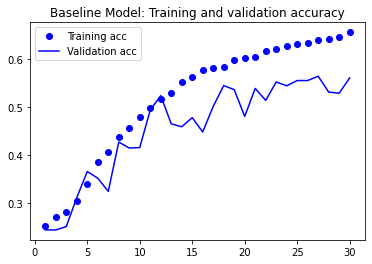

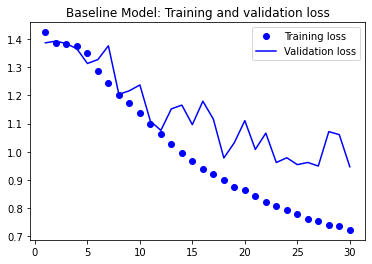

In [ ]:
#Plot performance of baseline model
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Baseline Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Baseline Model: Training and validation loss')
plt.legend()
plt.show()

Our training accuracy peaked at ~65% with a validation accuracy peaking at 56.44%. This clearly beats our target baseline. The next step is to add capacity to our model to learn more information while training.

####6. Developing a Model That Overfits
In order to create a model that overfits, we will increase the number of convolutional layers, max pooling layers, and dense layers to create and store more information about the images. 

In [ ]:
#Overfitting model with high capacity
from keras import layers
from keras import models

overfitting_model = models.Sequential()
overfitting_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
overfitting_model.add(layers.MaxPooling2D((2, 2)))
overfitting_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
overfitting_model.add(layers.MaxPooling2D((2, 2)))
overfitting_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
overfitting_model.add(layers.MaxPooling2D((2, 2)))
overfitting_model.add(layers.Flatten())
overfitting_model.add(layers.Dense(512, activation='relu'))
overfitting_model.add(layers.Dense(256, activation='relu'))
overfitting_model.add(layers.Dense(128, activation='relu'))
overfitting_model.add(layers.Dense(64, activation='relu'))
overfitting_model.add(layers.Dense(32, activation='relu'))
overfitting_model.add(layers.Dense(5, activation='softmax'))

In [ ]:
overfitting_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 18, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5120)             

Our overfitting model had 3 convolutional layers, 3 max pooling layers, and 6 dense layers, with a total of 2,889,925 trainable parameters. 

In [ ]:
#Compile the overfitting model

from keras import optimizers
overfitting_model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

In [ ]:
#Fit overfitting model
history2 = overfitting_model.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 2s 8ms/step - loss: 1.4093 - categorical_accuracy: 0.2486 - val_loss: 1.3900 - val_categorical_accuracy: 0.2510
Epoch 2/30
251/251 [==============================] - 2s 7ms/step - loss: 1.3914 - categorical_accuracy: 0.2540 - val_loss: 1.3851 - val_categorical_accuracy: 0.2510
Epoch 3/30
251/251 [==============================] - 2s 7ms/step - loss: 1.2927 - categorical_accuracy: 0.3769 - val_loss: 1.3530 - val_categorical_accuracy: 0.3179
Epoch 4/30
251/251 [==============================] - 2s 7ms/step - loss: 1.1142 - categorical_accuracy: 0.4877 - val_loss: 0.9158 - val_categorical_accuracy: 0.5883
Epoch 5/30
251/251 [==============================] - 2s 7ms/step - loss: 0.9889 - categorical_accuracy: 0.5504 - val_loss: 1.1098 - val_categorical_accuracy: 0.4666
Epoch 6/30
251/251 [==============================] - 2s 7ms/step - loss: 0.8142 - categorical_accuracy: 0.6267 - val_loss: 1.4409 - val_categorical_accuracy: 0.3528
Epoc

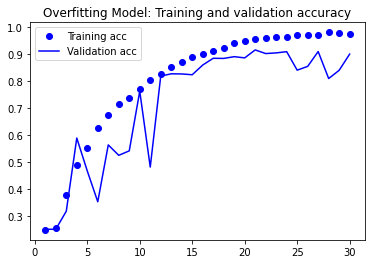

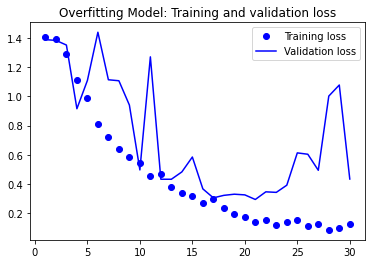

In [ ]:
#Plot performance of overfitting model
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model: Training and validation loss')
plt.legend()
plt.show()

The model has a nearly 100% training accuracy but validation accuracy plateaued at around the 17th epoch around 90%. From this, we can see that there is too much capacity and the model is overfitting. Despite this, our classifier has excellent performance, with room for improvement on generalizability.

We will now attempt to reduce overfitting via the following methods to :
1.   Add dropout
2.   Reducing the capacity of the network
3.   Add weight regularization
4.   Perform data augmentation (Note: the data has already been augmented, so we will not be exploring this further)


In [ ]:
#Overfitting model with dropout
from keras import layers
from keras import models
from keras.layers import Dropout

dropout_model = models.Sequential()
dropout_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dense(256, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(layers.Dense(128, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(layers.Dense(64, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(layers.Dense(32, activation='relu'))
dropout_model.add(Dropout(0.2))
dropout_model.add(layers.Dense(5, activation='softmax'))

#Compile the dropout model
from keras import optimizers
dropout_model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit dropout model
history3 = dropout_model.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 2s 7ms/step - loss: 1.4420 - categorical_accuracy: 0.2491 - val_loss: 1.3910 - val_categorical_accuracy: 0.2510
Epoch 2/30
251/251 [==============================] - 2s 7ms/step - loss: 1.4040 - categorical_accuracy: 0.2470 - val_loss: 1.3921 - val_categorical_accuracy: 0.2520
Epoch 3/30
251/251 [==============================] - 2s 7ms/step - loss: 1.3903 - categorical_accuracy: 0.2693 - val_loss: 1.3535 - val_categorical_accuracy: 0.3668
Epoch 4/30
251/251 [==============================] - 2s 7ms/step - loss: 1.2950 - categorical_accuracy: 0.3846 - val_loss: 1.3025 - val_categorical_accuracy: 0.3772
Epoch 5/30
251/251 [==============================] - 2s 7ms/step - loss: 1.1049 - categorical_accuracy: 0.5054 - val_loss: 0.8729 - val_categorical_accuracy: 0.6252
Epoch 6/30
251/251 [==============================] - 2s 7ms/step - loss: 0.9680 - categorical_accuracy: 0.5726 - val_loss: 1.0121 - val_categorical_accuracy: 0.5364
Epoc

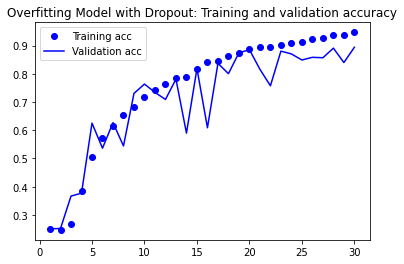

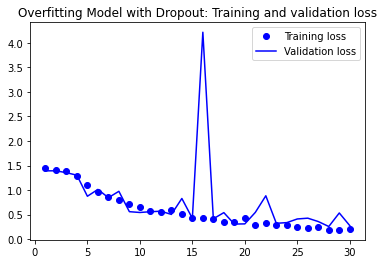

In [ ]:
#Plot performance of overfitting model with dropout
acc = history3.history['categorical_accuracy']
val_acc = history3.history['val_categorical_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with Dropout: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with Dropout: Training and validation loss')
plt.legend()
plt.show()

We trained this model for 30 epochs, yielding a peak 94.71% training accuracy and peak validation accuracy of 89.37%. The validation accuracy still plateaued, but progressed through more epochs before doing so. This suggests that dropout between dense layers = 0.2  helped prevent overfitting, however more work can be done. Thus, we will try another dropout model with a higher dropout rate to determine if it will mitigate overfitting.

In [ ]:
#Overfitting model with dropout of 0.4
from keras import layers
from keras import models
from keras.layers import Dropout

dropout_model_2 = models.Sequential()
dropout_model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
dropout_model_2.add(layers.MaxPooling2D((2, 2)))
dropout_model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model_2.add(layers.MaxPooling2D((2, 2)))
dropout_model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model_2.add(layers.MaxPooling2D((2, 2)))
dropout_model_2.add(layers.Flatten())
dropout_model_2.add(layers.Dense(256, activation='relu'))
dropout_model_2.add(Dropout(0.4)) #dropout layers
dropout_model_2.add(layers.Dense(128, activation='relu'))
dropout_model_2.add(Dropout(0.4))
dropout_model_2.add(layers.Dense(64, activation='relu'))
dropout_model_2.add(Dropout(0.4))
dropout_model_2.add(layers.Dense(32, activation='relu'))
dropout_model_2.add(Dropout(0.4))
dropout_model_2.add(layers.Dense(5, activation='softmax'))

#Compile the dropout model
from keras import optimizers
dropout_model_2.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit dropout model
history4 = dropout_model_2.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 2s 7ms/step - loss: 1.4905 - categorical_accuracy: 0.2411 - val_loss: 1.4045 - val_categorical_accuracy: 0.2520
Epoch 2/30
251/251 [==============================] - 2s 7ms/step - loss: 1.4157 - categorical_accuracy: 0.2522 - val_loss: 1.3837 - val_categorical_accuracy: 0.2660
Epoch 3/30
251/251 [==============================] - 2s 7ms/step - loss: 1.2999 - categorical_accuracy: 0.3682 - val_loss: 1.3741 - val_categorical_accuracy: 0.3698
Epoch 4/30
251/251 [==============================] - 2s 7ms/step - loss: 1.1176 - categorical_accuracy: 0.4948 - val_loss: 0.9837 - val_categorical_accuracy: 0.5559
Epoch 5/30
251/251 [==============================] - 2s 7ms/step - loss: 1.0092 - categorical_accuracy: 0.5469 - val_loss: 0.9160 - val_categorical_accuracy: 0.5948
Epoch 6/30
251/251 [==============================] - 2s 7ms/step - loss: 0.9184 - categorical_accuracy: 0.5930 - val_loss: 1.1330 - val_categorical_accuracy: 0.4721
Epoc

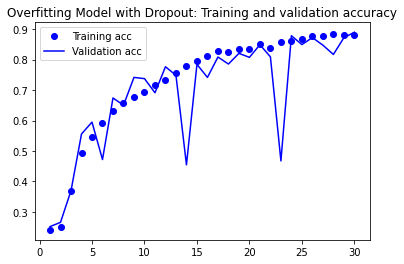

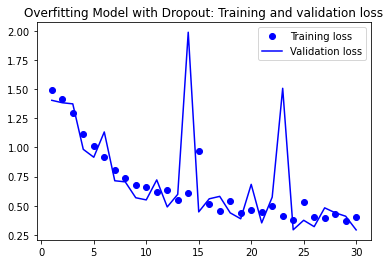

In [ ]:
#Plot performance of overfitting model with dropout = 0.4
acc = history4.history['categorical_accuracy']
val_acc = history4.history['val_categorical_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with Dropout: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with Dropout: Training and validation loss')
plt.legend()
plt.show()

Using a dropout of 0.4 for 30 epochs yielded a peak training accuracy of 88.32% and peak validation accuracy of 88.97%. The validation accuracy barely plateaued at the end, with the training and validation accuracies nearly identical. Thus, dropout = 0.4 seemed to mitigate overfitting more than dropout = 0.2 at a small performance cost.

Next, we will reduce the capacity of our model to remove some of the parameters the model can use to over-learn the training data.

In [ ]:
#Overfitting model with reduced capacity
from keras import layers
from keras import models

reduced_capacity_model = models.Sequential()
reduced_capacity_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
reduced_capacity_model.add(layers.MaxPooling2D((2, 2)))
reduced_capacity_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
reduced_capacity_model.add(layers.MaxPooling2D((2, 2)))
reduced_capacity_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
reduced_capacity_model.add(layers.MaxPooling2D((2, 2)))
reduced_capacity_model.add(layers.Flatten())
#top two dense layers removed
reduced_capacity_model.add(layers.Dense(128, activation='relu'))
reduced_capacity_model.add(layers.Dense(64, activation='relu'))
reduced_capacity_model.add(layers.Dense(32, activation='relu'))
reduced_capacity_model.add(layers.Dense(5, activation='softmax'))

#Compile the overfitting model with reduced capacity
from keras import optimizers
reduced_capacity_model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit the overfitting model with reduced capacity
history5 = reduced_capacity_model.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 2s 7ms/step - loss: 1.4076 - categorical_accuracy: 0.2591 - val_loss: 1.2923 - val_categorical_accuracy: 0.3957
Epoch 2/30
251/251 [==============================] - 2s 6ms/step - loss: 1.1868 - categorical_accuracy: 0.4480 - val_loss: 1.1617 - val_categorical_accuracy: 0.4511
Epoch 3/30
251/251 [==============================] - 2s 7ms/step - loss: 0.9925 - categorical_accuracy: 0.5495 - val_loss: 0.9298 - val_categorical_accuracy: 0.5833
Epoch 4/30
251/251 [==============================] - 2s 7ms/step - loss: 0.8348 - categorical_accuracy: 0.6250 - val_loss: 0.9849 - val_categorical_accuracy: 0.5988
Epoch 5/30
251/251 [==============================] - 2s 7ms/step - loss: 0.7244 - categorical_accuracy: 0.6803 - val_loss: 0.8296 - val_categorical_accuracy: 0.6128
Epoch 6/30
251/251 [==============================] - 2s 7ms/step - loss: 0.6040 - categorical_accuracy: 0.7373 - val_loss: 0.4933 - val_categorical_accuracy: 0.7650
Epoc

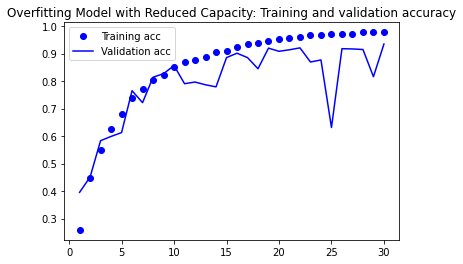

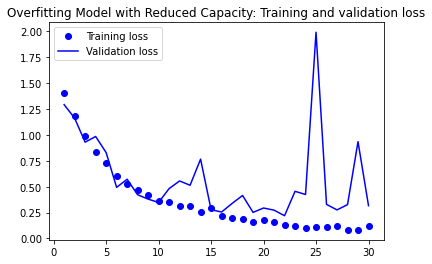

In [ ]:
#Plot performance of overfitting model with reduced capacity
acc = history5.history['categorical_accuracy']
val_acc = history5.history['val_categorical_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with Reduced Capacity: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with Reduced Capacity: Training and validation loss')
plt.legend()
plt.show()

This reduced capacity model took the trainable parameters from 2,889,925 to 759,237.

This new architecture yielded a peak training accuracy of 97.74% and a peak validation accuracy of 93.46%. The validation accuracy was very high, but it did plateau around epoch 15 with high volatility thereafter. This discrepancy with the plateau suggests overfitting, but did yield our highest validation accuracy yet. 

Next we will try weight and activity regularization.

In [ ]:
#Overfitting model with activityregularization applied
from keras import layers
from keras import models
# import regularizer
from keras.regularizers import l1
from keras.regularizers import l2
# instantiate regularizer
reg1 = l1(0.001)
reg2 = l2(0.001)

regularization_model = models.Sequential()
regularization_model.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
regularization_model.add(layers.MaxPooling2D((2, 2)))
regularization_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
regularization_model.add(layers.MaxPooling2D((2, 2)))
regularization_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
regularization_model.add(layers.MaxPooling2D((2, 2)))
regularization_model.add(layers.Flatten())
regularization_model.add(layers.Dense(256, activation='relu', activity_regularizer=l2(0.005))) #add activity regularizers
regularization_model.add(layers.Dense(128, activation='relu', activity_regularizer=l2(0.005)))
regularization_model.add(layers.Dense(64, activation='relu', activity_regularizer=l2(0.005)))
regularization_model.add(layers.Dense(32, activation='relu', activity_regularizer=l1(0.005)))
regularization_model.add(layers.Dense(5, activation='softmax'))

#Compile the overfitting model with regularization
from keras import optimizers
regularization_model.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit overfitting model with regularization
history6 = regularization_model.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 2s 8ms/step - loss: 1.4571 - categorical_accuracy: 0.2721 - val_loss: 1.3766 - val_categorical_accuracy: 0.3558
Epoch 2/30
251/251 [==============================] - 2s 7ms/step - loss: 1.2311 - categorical_accuracy: 0.4242 - val_loss: 1.3537 - val_categorical_accuracy: 0.4237
Epoch 3/30
251/251 [==============================] - 2s 7ms/step - loss: 1.0915 - categorical_accuracy: 0.4922 - val_loss: 1.1080 - val_categorical_accuracy: 0.4855
Epoch 4/30
251/251 [==============================] - 2s 7ms/step - loss: 0.9748 - categorical_accuracy: 0.5651 - val_loss: 0.8611 - val_categorical_accuracy: 0.6387
Epoch 5/30
251/251 [==============================] - 2s 7ms/step - loss: 0.7940 - categorical_accuracy: 0.6607 - val_loss: 1.2109 - val_categorical_accuracy: 0.4970
Epoch 6/30
251/251 [==============================] - 2s 7ms/step - loss: 0.6569 - categorical_accuracy: 0.7348 - val_loss: 0.5829 - val_categorical_accuracy: 0.7730
Epoc

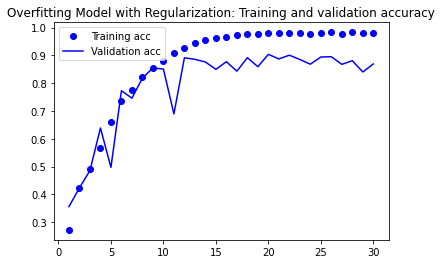

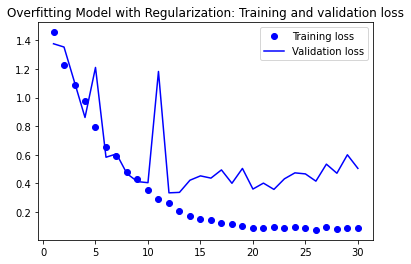

In [ ]:
#Plot performance of overfitting model with regularization
acc = history6.history['categorical_accuracy']
val_acc = history6.history['val_categorical_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with Regularization: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with Regularization: Training and validation loss')
plt.legend()
plt.show()

Using L2 activity regularization of 0.005 on the dense layers yielded a peak training accuracy of 98.33% with a peak validation accuracy of 90.37%. This is a large gap and the training accuracy plateaus around epoch 12, suggesting overfitting.

In [ ]:
#Overfitting model with weight regularization applied
from keras import layers
from keras import models
# import regularizer
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)

regularization_model_2 = models.Sequential()
regularization_model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
regularization_model_2.add(layers.MaxPooling2D((2, 2)))
regularization_model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
regularization_model_2.add(layers.MaxPooling2D((2, 2)))
regularization_model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
regularization_model_2.add(layers.MaxPooling2D((2, 2)))
regularization_model_2.add(layers.Flatten())
regularization_model_2.add(layers.Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))) #l1 and l2 weight regularization
regularization_model_2.add(layers.Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
regularization_model_2.add(layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
regularization_model_2.add(layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
regularization_model_2.add(layers.Dense(5, activation='softmax'))

#Compile the overfitting model with weight regularization applied
from keras import optimizers
regularization_model_2.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit the overfitting model with weight regularization applied
history7 = regularization_model_2.fit(X_train, y_train_1_hot, epochs=50, validation_data= (X_val, y_val_1_hot))

Epoch 1/50
251/251 [==============================] - 2s 8ms/step - loss: 1.7252 - categorical_accuracy: 0.2497 - val_loss: 1.4918 - val_categorical_accuracy: 0.2510
Epoch 2/50
251/251 [==============================] - 2s 7ms/step - loss: 1.4789 - categorical_accuracy: 0.2537 - val_loss: 1.4681 - val_categorical_accuracy: 0.2869
Epoch 3/50
251/251 [==============================] - 2s 7ms/step - loss: 1.4431 - categorical_accuracy: 0.2910 - val_loss: 1.3759 - val_categorical_accuracy: 0.3288
Epoch 4/50
251/251 [==============================] - 2s 7ms/step - loss: 1.2850 - categorical_accuracy: 0.4249 - val_loss: 1.2291 - val_categorical_accuracy: 0.4461
Epoch 5/50
251/251 [==============================] - 2s 7ms/step - loss: 1.1709 - categorical_accuracy: 0.4801 - val_loss: 1.1703 - val_categorical_accuracy: 0.5190
Epoch 6/50
251/251 [==============================] - 2s 7ms/step - loss: 1.1223 - categorical_accuracy: 0.4926 - val_loss: 1.3909 - val_categorical_accuracy: 0.3483
Epoc

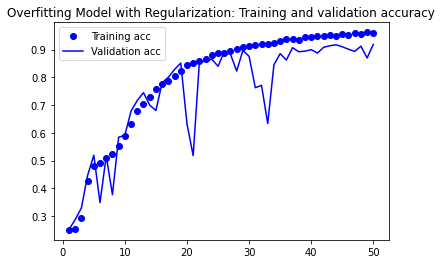

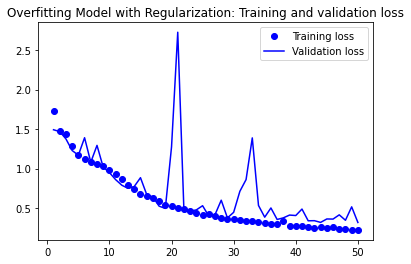

In [ ]:
#Plot performance of overfitting model with regularization
acc = history7.history['categorical_accuracy']
val_acc = history7.history['val_categorical_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with Regularization: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with Regularization: Training and validation loss')
plt.legend()
plt.show()

This model produced a peak training accuracy of 96.24% and peak validation accuracy of 91.87%. The validation accuracy did plateau, however it did so at higher epochs. This differential was smaller than other methods to mitigate overfitting, suggesting that weight regularization can help combat overfitting and thus could be used in our final model.

Next, we will try transfer learning via downloading convolutional bases from pre-trained CNNs and using them to extract features. Our own dense layers will sit under the base, learning the information for our specific task.

The pre-trained CNNs tested were VGG16 and ResNet50. These are well regarded as the top pre-trained CNNs for image classification. 

In [ ]:
#Try transfer learning with VGG16 convolutional base
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(60, 80, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 60, 80, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 80, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 80, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 40, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 40, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 15, 20, 128)       0     

In [ ]:
# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

In [ ]:
#Create a dense model
from keras import layers
from keras import models
transfer = models.Sequential()

#Add existing vgg16
transfer.add(vgg16)

#Add new
transfer.add(layers.Flatten())
transfer.add(layers.Dense(512, activation='relu'))
transfer.add(layers.Dense(256, activation='relu'))
transfer.add(layers.Dense(128, activation='relu'))
transfer.add(layers.Dense(64, activation='relu'))
transfer.add(layers.Dense(32, activation='relu'))
transfer.add(layers.Dense(5, activation='softmax'))

transfer.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 2, 512)         14714688  
_________________________________________________________________
flatten_21 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_94 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_95 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_96 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_97 (Dense)             (None, 32)              

In [ ]:
#Compile the combined model
from keras import optimizers
transfer.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

#Fit baseline model
history8 = transfer.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 4s 17ms/step - loss: 1.2798 - categorical_accuracy: 0.4192 - recall: 0.0503 - val_loss: 1.1906 - val_categorical_accuracy: 0.4666 - val_recall: 0.1487
Epoch 2/30
251/251 [==============================] - 4s 16ms/step - loss: 1.0750 - categorical_accuracy: 0.5506 - recall: 0.2461 - val_loss: 1.0499 - val_categorical_accuracy: 0.5349 - val_recall: 0.2934
Epoch 3/30
251/251 [==============================] - 4s 16ms/step - loss: 0.9500 - categorical_accuracy: 0.6064 - recall: 0.3957 - val_loss: 0.9675 - val_categorical_accuracy: 0.5833 - val_recall: 0.4122
Epoch 4/30
251/251 [==============================] - 4s 16ms/step - loss: 0.8649 - categorical_accuracy: 0.6489 - recall: 0.4949 - val_loss: 0.9442 - val_categorical_accuracy: 0.6088 - val_recall: 0.5000
Epoch 5/30
251/251 [==============================] - 4s 16ms/step - loss: 0.8064 - categorical_accuracy: 0.6739 - recall: 0.5526 - val_loss: 0.8563 - val_categorical_accuracy: 0.6

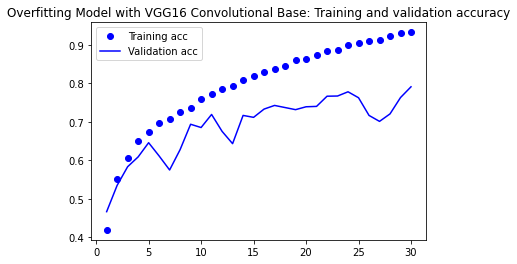

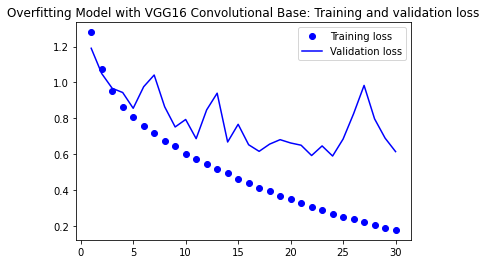

In [ ]:
#Plot performance of overfitting model with VGG16 Convolutional Base
acc = history8.history['categorical_accuracy']
val_acc = history8.history['val_categorical_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with VGG16 Convolutional Base: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with VGG16 Convolutional Base: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#import ResNet50 model
from keras.applications.resnet50 import ResNet50
resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(60, 80, 3))
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 60, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 66, 86, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 30, 40, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 30, 40, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Freeze all the conv layers
for layer in resnet.layers[:]:
    layer.trainable = False

In [ ]:
#Create a dense model
from keras import layers
from keras import models
transfer_2 = models.Sequential()

#Add existing resnet
transfer_2.add(resnet)

#Add new
transfer_2.add(layers.Flatten())
transfer_2.add(layers.Dense(512, activation='relu'))
transfer_2.add(layers.Dense(256, activation='relu'))
transfer_2.add(layers.Dense(128, activation='relu'))
transfer_2.add(layers.Dense(64, activation='relu'))
transfer_2.add(layers.Dense(32, activation='relu'))
transfer_2.add(layers.Dense(5, activation='softmax'))

transfer_2.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 3, 2048)        23587712  
_________________________________________________________________
flatten_22 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_99 (Dense)             (None, 512)               6291968   
_________________________________________________________________
dense_100 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_101 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_102 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_103 (Dense)            (None, 32)              

In [ ]:
#Compile the resnet
from keras import optimizers
transfer_2.compile(loss='categorical_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['categorical_accuracy', 'Recall'])

#Fit resnet
history9 = transfer_2.fit(X_train, y_train_1_hot, epochs=30, validation_data= (X_val, y_val_1_hot))

Epoch 1/30
251/251 [==============================] - 6s 24ms/step - loss: 1.4033 - categorical_accuracy: 0.2677 - recall: 0.0000e+00 - val_loss: 1.4067 - val_categorical_accuracy: 0.2465 - val_recall: 0.0000e+00
Epoch 2/30
251/251 [==============================] - 5s 21ms/step - loss: 1.3719 - categorical_accuracy: 0.3028 - recall: 0.0017 - val_loss: 1.3548 - val_categorical_accuracy: 0.3423 - val_recall: 0.0030
Epoch 3/30
251/251 [==============================] - 5s 21ms/step - loss: 1.3393 - categorical_accuracy: 0.3343 - recall: 0.0309 - val_loss: 1.3182 - val_categorical_accuracy: 0.3473 - val_recall: 0.0564
Epoch 4/30
251/251 [==============================] - 5s 21ms/step - loss: 1.3176 - categorical_accuracy: 0.3472 - recall: 0.0584 - val_loss: 1.3094 - val_categorical_accuracy: 0.3658 - val_recall: 0.0364
Epoch 5/30
251/251 [==============================] - 5s 21ms/step - loss: 1.3008 - categorical_accuracy: 0.3593 - recall: 0.0726 - val_loss: 1.3098 - val_categorical_accur

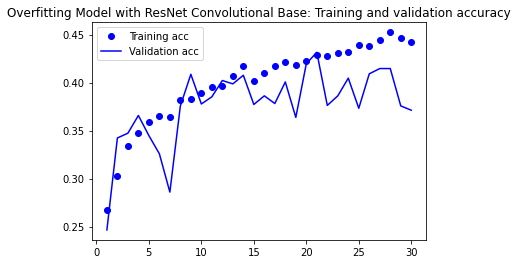

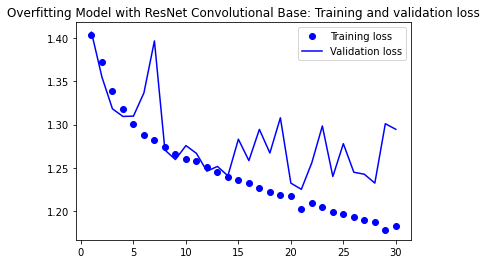

In [ ]:
#Plot performance of overfitting model with ResNet Convolutional Base
acc = history9.history['categorical_accuracy']
val_acc = history9.history['val_categorical_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Overfitting Model with ResNet Convolutional Base: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Overfitting Model with ResNet Convolutional Base: Training and validation loss')
plt.legend()
plt.show()

VGG16 yielded the best performance, although it overfit drastically. This was expected as it had many more convolutional layers than our first overfitting model. VGG16 could be leveraged with the other techniques to potentially create our final model.

### Finalizing Our Model
To create our final model, we will experiment with a combination of the techniques explored in the previous section. We will start with the two most powerful (reduced capacity and weight regularization), and explore other combinations as well. Just because these strategies work well independently doesn't mean they'll work well together. Thus, some exploration and additional hyperparameter tuning will be performed to determine the best model.

In [ ]:
# Model with reduced capacity and regularization applied
from keras import layers
from keras import models
# import regularizer
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)

final_model_1 = models.Sequential()
final_model_1.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
final_model_1.add(layers.MaxPooling2D((2, 2)))
final_model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
final_model_1.add(layers.MaxPooling2D((2, 2)))
final_model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
final_model_1.add(layers.MaxPooling2D((2, 2)))
final_model_1.add(layers.Flatten())
final_model_1.add(layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
final_model_1.add(layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
final_model_1.add(layers.Dense(5, activation='softmax'))

#Compile the overfitting model

from keras import optimizers
final_model_1.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit the model
history11 = final_model_1.fit(X_train, y_train_1_hot, epochs=50, validation_data= (X_val, y_val_1_hot))

Epoch 1/50
251/251 [==============================] - 2s 7ms/step - loss: 1.4997 - categorical_accuracy: 0.2556 - val_loss: 1.4071 - val_categorical_accuracy: 0.2864
Epoch 2/50
251/251 [==============================] - 1s 6ms/step - loss: 1.3639 - categorical_accuracy: 0.3318 - val_loss: 1.3497 - val_categorical_accuracy: 0.3408
Epoch 3/50
251/251 [==============================] - 1s 6ms/step - loss: 1.2238 - categorical_accuracy: 0.4202 - val_loss: 1.1714 - val_categorical_accuracy: 0.4182
Epoch 4/50
251/251 [==============================] - 1s 6ms/step - loss: 1.0958 - categorical_accuracy: 0.4885 - val_loss: 1.2371 - val_categorical_accuracy: 0.4247
Epoch 5/50
251/251 [==============================] - 1s 6ms/step - loss: 1.0214 - categorical_accuracy: 0.5300 - val_loss: 1.4525 - val_categorical_accuracy: 0.4606
Epoch 6/50
251/251 [==============================] - 1s 6ms/step - loss: 0.8856 - categorical_accuracy: 0.6391 - val_loss: 1.7564 - val_categorical_accuracy: 0.4855
Epoc

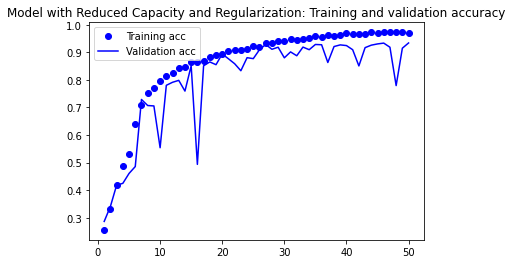

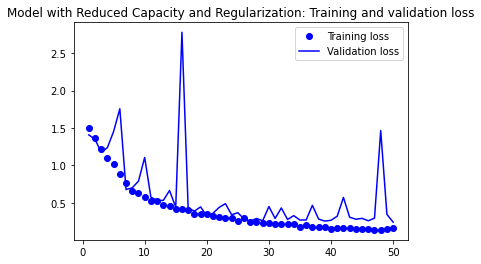

In [ ]:
#Plot performance of model with reduced capacity and regularization
acc = history11.history['categorical_accuracy']
val_acc = history11.history['val_categorical_accuracy']
loss = history11.history['loss']
val_loss = history11.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model with Reduced Capacity and Regularization: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model with Reduced Capacity and Regularization: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Model with reduced capacity, dropout, and regularization applied
from keras import layers
from keras import models
from keras.layers import Dropout
# import regularizer
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)

final_model_2 = models.Sequential()
final_model_2.add(layers.Conv2D(32, (3, 3), activation='relu',
input_shape=(60, 80, 3)))
final_model_2.add(layers.MaxPooling2D((2, 2)))
final_model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
final_model_2.add(layers.MaxPooling2D((2, 2)))
final_model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
final_model_2.add(layers.MaxPooling2D((2, 2)))
final_model_2.add(layers.Flatten())
final_model_2.add(layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
final_model_2.add(Dropout(0.2))
final_model_2.add(layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
final_model_2.add(Dropout(0.2))
final_model_2.add(layers.Dense(5, activation='softmax'))

#Compile the model with reduced capacity, dropout, and regularization applied

from keras import optimizers
final_model_2.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit the model with reduced capacity, dropout, and regularization applied
history12 = final_model_2.fit(X_train, y_train_1_hot, epochs=50, validation_data= (X_val, y_val_1_hot))

Epoch 1/50
251/251 [==============================] - 2s 7ms/step - loss: 1.5291 - categorical_accuracy: 0.2578 - val_loss: 1.3796 - val_categorical_accuracy: 0.3194
Epoch 2/50
251/251 [==============================] - 2s 6ms/step - loss: 1.3313 - categorical_accuracy: 0.3637 - val_loss: 1.4851 - val_categorical_accuracy: 0.2824
Epoch 3/50
251/251 [==============================] - 2s 6ms/step - loss: 1.1845 - categorical_accuracy: 0.4481 - val_loss: 1.1313 - val_categorical_accuracy: 0.4870
Epoch 4/50
251/251 [==============================] - 2s 6ms/step - loss: 1.1045 - categorical_accuracy: 0.4759 - val_loss: 1.1641 - val_categorical_accuracy: 0.4461
Epoch 5/50
251/251 [==============================] - 2s 6ms/step - loss: 1.0781 - categorical_accuracy: 0.4881 - val_loss: 1.0305 - val_categorical_accuracy: 0.5334
Epoch 6/50
251/251 [==============================] - 2s 6ms/step - loss: 1.0178 - categorical_accuracy: 0.5460 - val_loss: 0.9140 - val_categorical_accuracy: 0.6492
Epoc

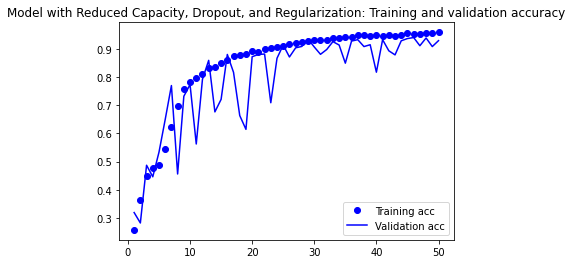

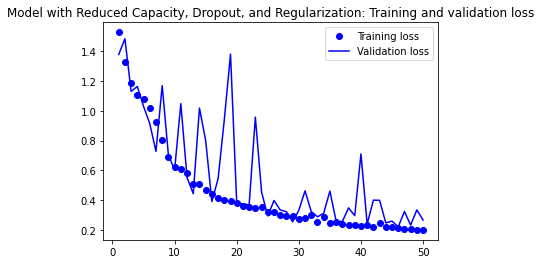

In [ ]:
#Plot performance of model with reduced capacity, dropout, and regularization
acc = history12.history['categorical_accuracy']
val_acc = history12.history['val_categorical_accuracy']
loss = history12.history['loss']
val_loss = history12.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model with Reduced Capacity, Dropout, and Regularization: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model with Reduced Capacity, Dropout, and Regularization: Training and validation loss')
plt.legend()
plt.show()

In [ ]:
#Adding in VGG16
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(60, 80, 3))

# Freeze all the conv layers
for layer in vgg16.layers[:]:
    layer.trainable = False

In [ ]:
# Model with reduced capacity, dropout, regularization, and transfer learning applied
from keras import layers
from keras import models
from keras.layers import Dropout
# import regularizer
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import l1_l2

keras.regularizers.l1_l2(l1=0.0001, l2=0.0001)

final_model_3 = models.Sequential()
final_model_3.add(vgg16)
final_model_3.add(layers.Flatten())
final_model_3.add(layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
final_model_3.add(Dropout(0.2))
final_model_3.add(layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001)))
final_model_3.add(Dropout(0.2))
final_model_3.add(layers.Dense(5, activation='softmax'))

#Compile the overfitting model

from keras import optimizers
final_model_3.compile(loss='categorical_crossentropy',
optimizer='rmsprop',
metrics=['categorical_accuracy'])

#Fit the model
history13 = final_model_3.fit(X_train, y_train_1_hot, epochs=50, validation_data= (X_val, y_val_1_hot))

Epoch 1/50
251/251 [==============================] - 4s 15ms/step - loss: 1.4248 - categorical_accuracy: 0.3860 - val_loss: 1.2088 - val_categorical_accuracy: 0.5045
Epoch 2/50
251/251 [==============================] - 4s 14ms/step - loss: 1.1832 - categorical_accuracy: 0.5234 - val_loss: 1.1809 - val_categorical_accuracy: 0.5140
Epoch 3/50
251/251 [==============================] - 4s 15ms/step - loss: 1.0835 - categorical_accuracy: 0.5794 - val_loss: 1.0983 - val_categorical_accuracy: 0.5519
Epoch 4/50
251/251 [==============================] - 4s 15ms/step - loss: 1.0059 - categorical_accuracy: 0.6197 - val_loss: 0.9742 - val_categorical_accuracy: 0.6337
Epoch 5/50
251/251 [==============================] - 4s 15ms/step - loss: 0.9647 - categorical_accuracy: 0.6484 - val_loss: 1.0398 - val_categorical_accuracy: 0.6198
Epoch 6/50
251/251 [==============================] - 4s 15ms/step - loss: 0.9354 - categorical_accuracy: 0.6563 - val_loss: 0.9953 - val_categorical_accuracy: 0.603

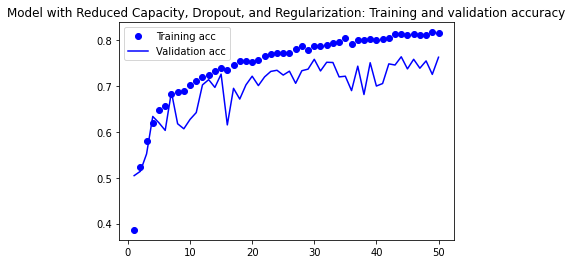

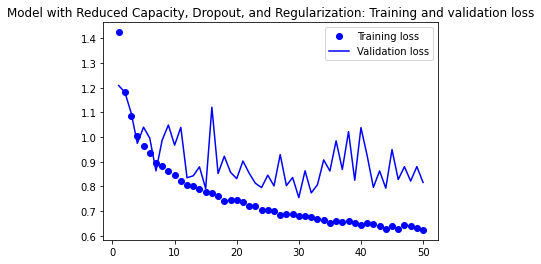

In [ ]:
#Plot performance of model with reduced capacity, dropout, and regularization
acc = history13.history['categorical_accuracy']
val_acc = history13.history['val_categorical_accuracy']
loss = history13.history['loss']
val_loss = history13.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model with Reduced Capacity, Dropout, and Regularization: Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model with Reduced Capacity, Dropout, and Regularization: Training and validation loss')
plt.legend()
plt.show()

From performance graphs and the verbose, we determined that our model with weight regularization, reduced capacity, and dropout performed the best. It had the highest validation accuracy and its graph suggests that it barely plateaus. 

With our final model assembled, we will now use the hold out validation set to determine our model's final performance.

In [ ]:
#predict classes for test set
y_pred = final_model_2.predict_classes(X_test)

In [ ]:
#get accuracy meetric
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8411741053478086

In [ ]:
#get confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[517,  85,  21,   1],
       [145, 475,   1,   2],
       [133,   6, 481,   0],
       [  0,   0,   1, 619]])

In [ ]:
#
from sklearn.metrics import classification_report
target_names = ['NEUTROPHIL','EOSINOPHIL','MONOCYTE','LYMPHOCYTE']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  NEUTROPHIL       0.65      0.83      0.73       624
  EOSINOPHIL       0.84      0.76      0.80       623
    MONOCYTE       0.95      0.78      0.86       620
  LYMPHOCYTE       1.00      1.00      1.00       620

    accuracy                           0.84      2487
   macro avg       0.86      0.84      0.85      2487
weighted avg       0.86      0.84      0.84      2487



In [ ]:
final_model_2.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 27, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 13, 18, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 11, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 5, 8, 128)         0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 5120)            